In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import bz2
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

ModuleNotFoundError: No module named 'tensorflow'

In [3]:
def labels_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts

In [4]:
train_label, train_text = labels_texts('C:\\Users\\zba19\\Documents\\Python Scripts\\nlp\\amazon\\train.ft.txt.bz2')
test_label, test_text = labels_texts('C:\\Users\\zba19\\Documents\\Python Scripts\\nlp\\amazon\\test.ft.txt.bz2')

In [5]:
# labels_mod = []
# texts_mod = []


In [6]:
print(train_label[0])
print(train_text[0])

1
Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^


In [6]:
train_label=train_label[0:200000]
train_text=train_text[0:200000]
test_label=test_label[0:100000]
test_text=test_text[0:100000]

In [7]:
test_label.shape

(100000,)

In [8]:
np.unique(train_label)

array([0, 1])

In [8]:
import re
not_numChar = re.compile(r'[\W]')
no_encode = re.compile(r'[^a-z0-1\s]')
def normalisation(texts):
    norm_text = []
    for word in texts:
        lower = word.lower()
        not_punct = not_numChar.sub(r' ', lower)
        exclude_no_encode = no_encode.sub(r'', not_punct)
        norm_text.append(exclude_no_encode)
    return norm_text

In [9]:
train_text = normalisation(train_text)
test_text = normalisation(test_text)

In [11]:
print(train_text[0])

stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    


In [10]:
y_train = np.array(train_label)
y_test = np.array(test_label)

In [11]:
y_test.shape

(100000,)

In [12]:
max_features = 8192
maxlen = 128
embed_size = 64

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_text)

In [13]:
training_token = tokenizer.texts_to_sequences(train_text)
testing_token = tokenizer.texts_to_sequences(test_text)

In [14]:
x_train = pad_sequences(training_token, maxlen = maxlen, padding = 'post')
x_test = pad_sequences(testing_token, maxlen = maxlen, padding = 'post')

In [18]:
x_train

array([[  74,   11,    1, ...,    0,    0,    0],
       [   1,   89, 1007, ...,    0,    0,    0],
       [ 352,    8, 1007, ...,  257,    0,    0],
       ...,
       [  25,    4,   31, ...,   48,  685, 1188],
       [  45,    9,    6, ...,    0,    0,    0],
       [ 613,    2,   64, ...,   19, 4298, 2134]])

In [ ]:

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strata = tf.distribute.experimental.TPUStrategy(tpu)

### fully connected convolutional 

In [36]:
BATCH_SIZE=128
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
    tf.keras.layers.MaxPooling1D(pool_size = 4),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile('adam', 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_test, y_test), verbose = 2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 128, 64)           524288    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 124, 64)           20544     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 31, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 27, 64)            20544     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

In [ ]:
BATCH_SIZE = 16* tpu_strata.num_replicas_in_sync
with tpu_strata.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv1D(64, 5, activation = 'relu'),
        tf.keras.layers.MaxPooling1D(pool_size = 4),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile('adam', 'binary_crossentropy', metrics = ['accuracy'], steps_per_execution=16)
    model.summary()

history = model.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_test, y_test), verbose = 2)

In [37]:
model.evaluate (x_test, y_test)

3125/3125 [==============================] - 36s 12ms/step - loss: 0.3256 - accuracy: 0.9035


[0.3256227672100067, 0.903469979763031]

<Figure size 432x288 with 0 Axes>

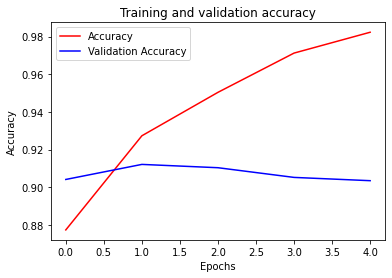

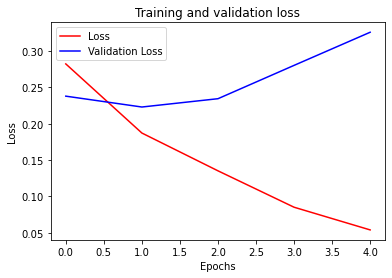

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

------------------------------------------------
### Using a bidirectional LSTM model

In [18]:
BATCH_SIZE = 64
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_lstm.compile('adam', 'binary_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_test, y_test), verbose = 2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           524288    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 553,345
Trainable params: 553,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3125/3125 - 385s - loss: 0.2576 - accuracy: 0.8931 - val_loss: 0.2207 - val_accuracy: 0.9144
Epoch 2/5
3125/3125 - 426s - loss: 0.1784 - accuracy: 0.9313 - val_loss: 0.2049 - val_accuracy: 0.9210
Epoch 3/5
3125/3125 - 412s - loss: 0.148

In [15]:
BATCH_SIZE = 64
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_lstm.compile('adam', 'binary_crossentropy', metrics = ['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_test, y_test), verbose = 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           524288    
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 64)           24832     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 576,065
Trainable params: 576,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3125/3125 - 763s - loss: 0.2762 - accuracy: 0.8858 - val_loss: 0.2287 - val_accuracy: 0.9097
Epoch 2/5
312

In [ ]:
BATCH_SIZE = 16* tpu_strata.num_replicas_in_sync
with tpu_strata.scope():
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, embed_size, input_length = maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    model_lstm.compile('adam', 'binary_crossentropy', metrics = ['accuracy'], steps_per_execution=16)
    model_lstm.summary()

history_lstm = model_lstm.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = 5, validation_data = (x_test, y_test), verbose = 2)

In [19]:
model_lstm.evaluate(x_test, y_test)

3125/3125 [==============================] - 77s 25ms/step - loss: 0.2585 - accuracy: 0.9185


[0.25851550698280334, 0.9184799790382385]

<Figure size 432x288 with 0 Axes>

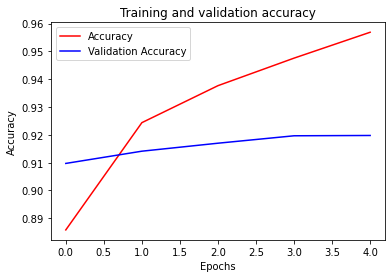

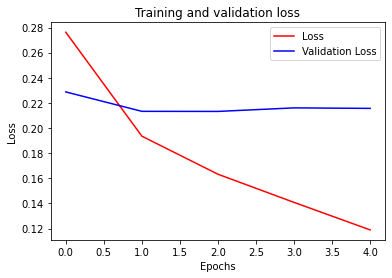

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.image  as mpimg

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history_lstm.history['accuracy']
val_acc=history_lstm.history['val_accuracy']
loss=history_lstm.history['loss']
val_loss=history_lstm.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

-------------------------------------------------------------------------------
## NLP using simple linear regression 

In [ ]:
# from sklearn.feattokenizerxtraction.text import CountVectorizer
# countVector = CountVectorizer(True)
# countVector.fit(train_text)
# x = countVector.transform(train_text)
# X_test = countVector.transform(test_text)